In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv'), delimiter=',')
data = data[:, 1:]
dataNorm = data/np.max(data)
dataT = torch.Tensor(dataNorm).float()

In [4]:
dataT.size()[0]

20000

In [5]:
class model(nn.Module):
    def __init__(self, encUnits, latUnits):
        super().__init__()

        self.input = nn.Linear(784, encUnits)
        self.enc = nn.Linear(encUnits, latUnits)
        self.lat = nn.Linear(latUnits, encUnits)
        self.dec = nn.Linear(encUnits, 784)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.enc(x))
        x = F.relu(self.lat(x))
        x = torch.sigmoid(self.dec(x))
        return x


In [6]:
def getModel(encUnits, latUnits):
    AENET = model(encUnits=encUnits, latUnits=latUnits)

    lossFunction = nn.MSELoss()

    optimizer = torch.optim.Adam(AENET.parameters(), lr=0.001)

    return AENET, lossFunction, optimizer


In [7]:
def trainModel(AENET, lossFunction, optimizer):

    epochs = 10

    losses = torch.zeros(epochs)

    for _ in range(epochs):
        batchLoss = []
        batchSize = 32
        startIdx = 0
        endIdx = batchSize
        # manually creating batches
        while(endIdx<dataT.size()[0]-1):
           X = dataT[startIdx:endIdx, :]
           startIdx = endIdx
           endIdx = endIdx+batchSize

           yHat = AENET(X)
           loss = lossFunction(yHat, X)

           optimizer.zero_grad()
           loss.backward()
           optimizer.step()
           batchLoss.append(loss.item())
        losses[_] = np.mean(batchLoss)
        # message = 'Loop {} completed'.format(_)
        # sys.stdout.write("\r" + str(message))

    return losses, AENET


In [37]:
# testing code

AENET, lossFunction, optimizer = getModel(250, 50)
losses, AENET = trainModel(AENET, lossFunction, optimizer)

Loop 9 completed

In [33]:
encUnits = np.linspace(10, 500, 12, dtype=int)
latUnits = np.linspace(5, 100, 8, dtype=int)
finalLosses = np.zeros((len(encUnits), len(latUnits)))
currentExp = 1
totalExp = len(encUnits)*len(latUnits)
for e in range(len(encUnits)):
    for l in range(len(latUnits)):
        AENET, lossFunction, optimizer = getModel(encUnits[e], latUnits[l])
        losses, AENET = trainModel(AENET, lossFunction, optimizer)
        finalLosses[e][l] = torch.mean(losses[:-3])

        message = 'Experiment {}/{} completed'.format(currentExp, totalExp)
        sys.stdout.write("\r" + str(message))
        currentExp+=1



Experiment 96/96 completed

In [34]:
finalLosses

array([[0.06969838, 0.04911296, 0.05587263, 0.05047159, 0.05599755,
        0.05290373, 0.05224048, 0.0542861 ],
       [0.0550819 , 0.03165747, 0.0270773 , 0.02919759, 0.02787803,
        0.02607229, 0.02557861, 0.02633226],
       [0.04057555, 0.02596782, 0.02497034, 0.02204377, 0.02232194,
        0.02112458, 0.01967847, 0.01992739],
       [0.0474143 , 0.02623151, 0.02218464, 0.02078611, 0.01879188,
        0.01783612, 0.01857703, 0.01759811],
       [0.04084305, 0.02185914, 0.02026771, 0.01830727, 0.01694019,
        0.01707262, 0.01657519, 0.01641895],
       [0.04176197, 0.02638645, 0.01892258, 0.01608487, 0.01655306,
        0.01563279, 0.0151853 , 0.01563043],
       [0.04015435, 0.02572834, 0.01878493, 0.01625301, 0.01563339,
        0.0152044 , 0.01449301, 0.0143871 ],
       [0.04053123, 0.02122919, 0.01628844, 0.01604101, 0.0147701 ,
        0.01405554, 0.01429671, 0.01439117],
       [0.04922903, 0.02401275, 0.01555869, 0.0147986 , 0.01348236,
        0.01324493, 0.013551

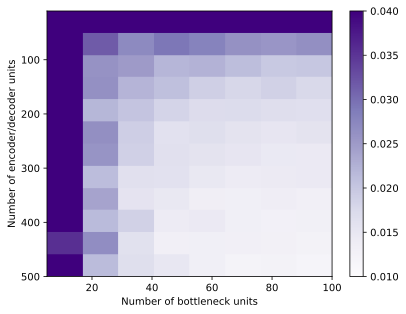

In [36]:
plt.imshow(finalLosses, 'Purples', aspect='auto', vmin=.01,vmax=.04,
           extent=[ latUnits[0],latUnits[-1],encUnits[-1],encUnits[0], ])
plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()
plt.show()

### More units in the latent layer means we're doing less compression hence more accurate the reconstruction (of image) is going to be. Usually you want the number of latent units to be small because you're compressioning/reducing the dimensionality. Adding more units will give better performance but that's not always the goal, it needs to be balanced with the other objectives of the application.